In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Read an image in grayscale

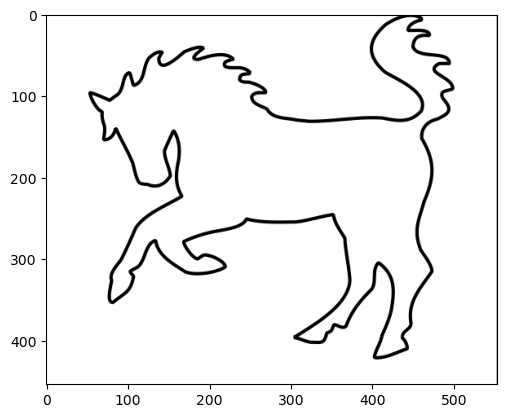

In [48]:
# Load image in grayscale
img = cv.imread('horse.png', cv.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

Find a threshold for contours

In [49]:
# Threshold to get binary image (you might need to tune threshold)
_, thresh = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)

Find contours

In [50]:
# Find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Sort contours by length and take the longest one (assume it's the horse)
contour = max(contours, key=cv.contourArea)

# Convert contour to a list of points
points = contour.squeeze()

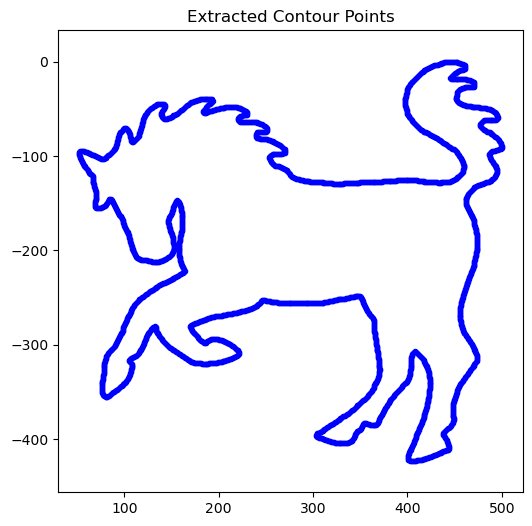

In [51]:
# Optionally plot the points
plt.figure(figsize=(6, 6))
plt.plot(points[:, 0], -points[:, 1], 'b.-')  # Invert y to match usual image coordinates
plt.title("Extracted Contour Points")
plt.axis("equal")
plt.show()

# Quadratic Bézier curve

In [52]:
# Bézier curve functions
def quadratic_bezier(p0, p1, p2, num_points=100):
    t = np.linspace(0, 1, num_points)
    return (1 - t)[:, None]**2 * p0 + 2 * (1 - t)[:, None]* t[:, None] * p1 + t[:, None]**2 * p2

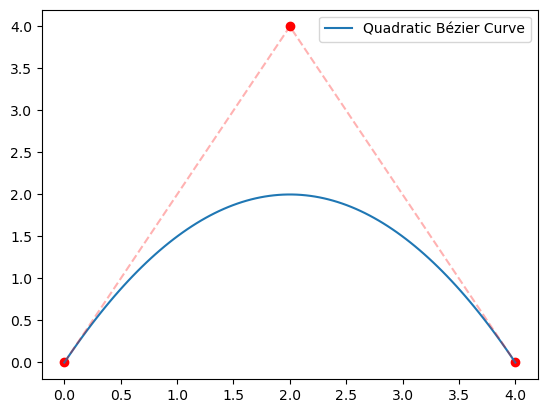

In [53]:
quad_p0 = np.array([0, 0])
quad_p1 = np.array([2, 4])
quad_p2 = np.array([4, 0])

quad_curve = quadratic_bezier(quad_p0, quad_p1, quad_p2, num_points=100)

# Plot Quadratic Bézier curve
plt.plot(quad_curve[:, 0], quad_curve[:, 1], label='Quadratic Bézier Curve')
plt.scatter(*zip(quad_p0, quad_p1, quad_p2), color='red')
plt.plot(*zip(quad_p0, quad_p1, quad_p2), 'r--', alpha=0.3)
plt.legend()
plt.show()

## First method

We will choose every tenth point and find the middle between them

In [54]:
# Choose new points
new_points = np.array([points[i] for i in range(0, points.shape[0], 10)])

# compute means between two points
midpoints = []
n = new_points.shape[0]
for i in range(0, n):
    p1 = new_points[i]
    p2 = new_points[(i + 1) %n]
    midpoints.append((p1 + p2) / 2)

midpoints = np.array(midpoints)

Now we will zoom in on the contour that is made up of the midpoints.

In [55]:
# Calculate the center of mass (average of all points)
center = np.mean(midpoints, axis=0)

#Scale (e.g. 1.2 = increase by 20%, 0.8 = decrease by 20%)
scale = 1.05

# Масштабуємо точки відносно центру
scaled_midpoints = (midpoints - center) * scale + center

Plot these points

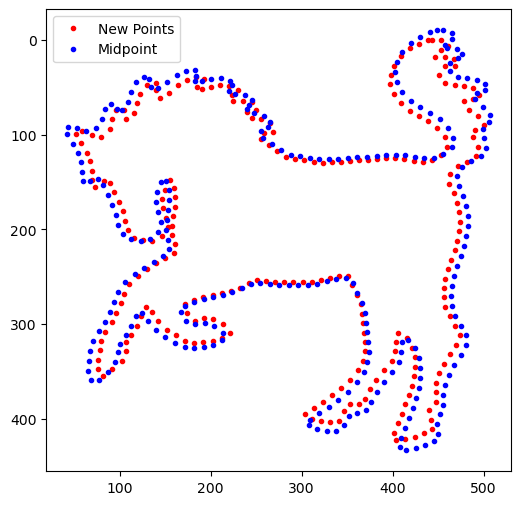

In [56]:
x = new_points[:, 0]
y = new_points[:, 1]

x_m = scaled_midpoints[:, 0]
y_m = scaled_midpoints[:, 1]

plt.figure(figsize=(6, 6))
plt.plot(x, y, 'r.', label='New Points')
plt.plot(x_m, y_m, 'b.', label='Midpoint')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Now build the Bézier curve based on these points

In [57]:
n = new_points.shape[0]
quad_curves = np.array([quadratic_bezier(new_points[i], scaled_midpoints[i], new_points[i + 1]) for i in range(0, n - 1)])

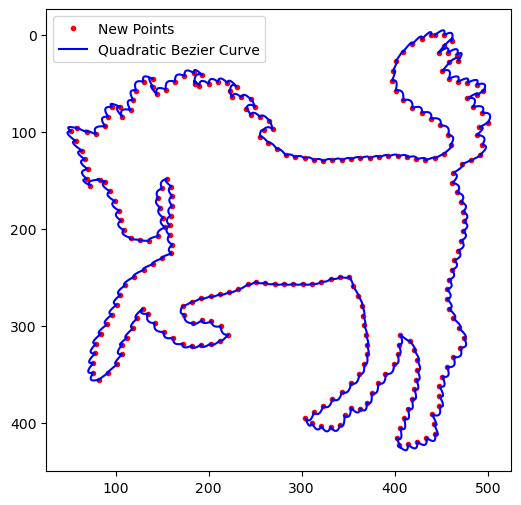

In [58]:
full_curve = np.concatenate(quad_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(new_points[:,0], new_points[:,1], 'r.', label='New Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Quadratic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Second Methods (without a midpoint)

In [59]:
n = new_points.shape[0]

# add start points to the end
loop_points = np.concatenate([new_points, new_points[:2]])
quad_curves = np.array([quadratic_bezier(loop_points[i], loop_points[i+1], loop_points[i+2]) for i in range(0, n-2,2)])

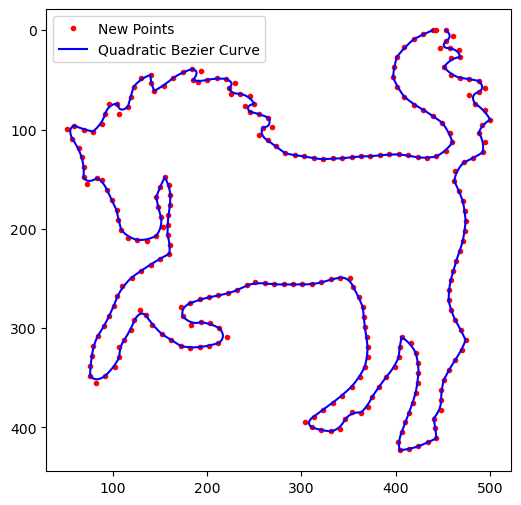

In [60]:
full_curve = np.concatenate(quad_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(new_points[:,0], new_points[:,1], 'r.', label='New Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Quadratic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Third method (only midpoint)

In [61]:
n = midpoints.shape[0]

# add start points to the end
loop_points = np.concatenate([midpoints, midpoints[:2]])
quad_curves = np.array([quadratic_bezier(loop_points[i], loop_points[i+1], loop_points[i+2]) for i in range(0, n-2,2)])

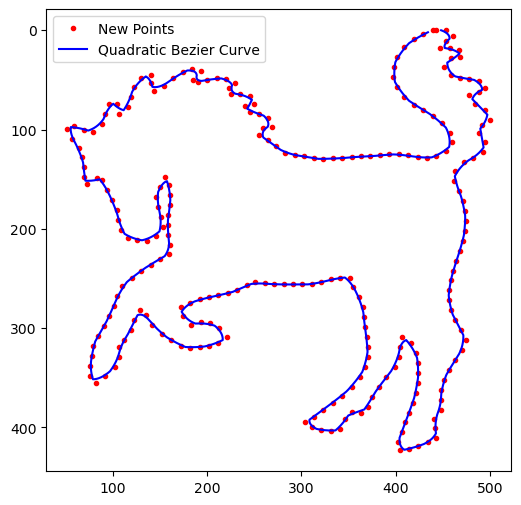

In [62]:
full_curve = np.concatenate(quad_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(new_points[:,0], new_points[:,1], 'r.', label='New Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Quadratic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Cubic Bézier curve

In [63]:
def cubic_bezier(p0, p1, p2, p3, num_points=100):
    t = np.linspace(0, 1, num_points)
    curve = (1 - t)[:, None] ** 3 * p0 + \
            3 * (1 - t)[:, None] ** 2 * t[:, None] * p1 + \
            3 * (1 - t)[:, None] * t[:, None] ** 2 * p2 + \
            t[:, None] ** 3 * p3
    return curve

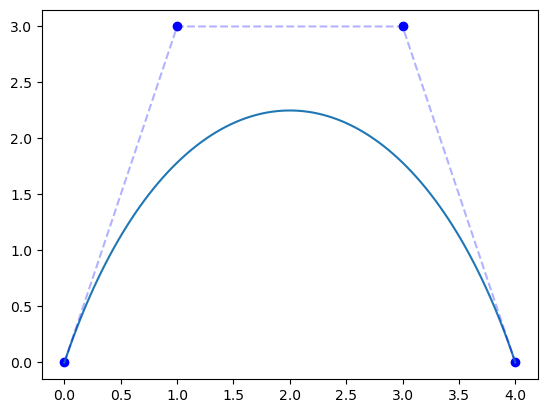

In [64]:
cubic_p0 = np.array([0, 0])
cubic_p1 = np.array([1, 3])
cubic_p2 = np.array([3, 3])
cubic_p3 = np.array([4, 0])

cubic_curve = cubic_bezier(cubic_p0, cubic_p1, cubic_p2, cubic_p3)

# Plot Cubic Bézier curve
plt.plot(cubic_curve[:, 0], cubic_curve[:, 1], label='Cubic Bézier Curve')
plt.scatter(*zip(cubic_p0, cubic_p1, cubic_p2, cubic_p3), color='blue')
plt.plot(*zip(cubic_p0, cubic_p1, cubic_p2, cubic_p3), 'b--', alpha=0.3)

## First method (only points)

In [65]:
n = points.shape[0]
# add start points to the end
loop_points = np.concatenate([points, points[:3]])
cubic_curves = np.array([cubic_bezier(loop_points[i], loop_points[i+1], loop_points[i+2], loop_points[i+3]) for i in range(0, n-3,3)])

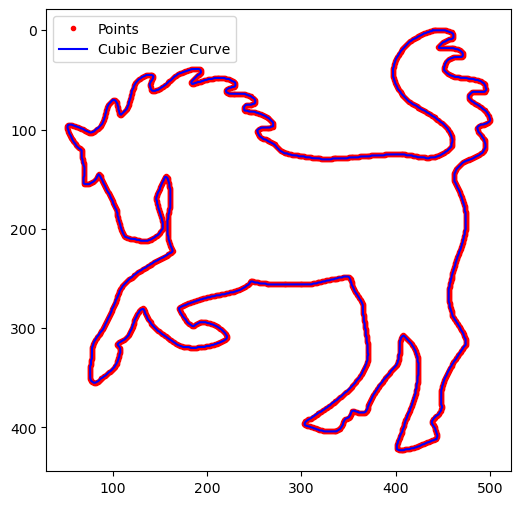

In [66]:
full_curve = np.concatenate(cubic_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(points[:,0], points[:,1], 'r.', label='Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Cubic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Second method (only new points)

In [67]:
n = new_points.shape[0]
# add start points to the end
loop_points = np.concatenate([new_points, new_points[:3]])
cubic_curves = np.array([cubic_bezier(loop_points[i], loop_points[i+1], loop_points[i+2], loop_points[i+3]) for i in range(0, n-3,3)])

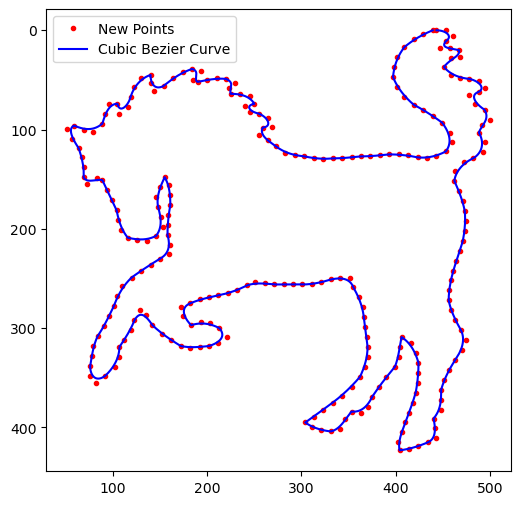

In [68]:
full_curve = np.concatenate(cubic_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(new_points[:,0], new_points[:,1], 'r.', label='New Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Cubic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Third method (only midpoints)

In [69]:
n = midpoints.shape[0]
# add start points to the end
loop_points = np.concatenate([midpoints, midpoints[:3]])
cubic_curves = np.array([cubic_bezier(loop_points[i], loop_points[i+1], loop_points[i+2], loop_points[i+3]) for i in range(0, n-3,3)])

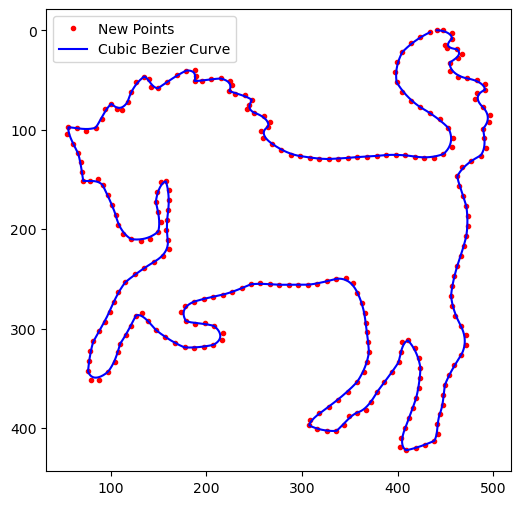

In [70]:
full_curve = np.concatenate(cubic_curves, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(midpoints[:, 0], midpoints[:, 1], 'r.', label='New Points')
plt.plot(full_curve[:, 0], full_curve[:, 1], 'b-', label='Cubic Bezier Curve')
plt.gca().invert_yaxis()
plt.legend()
plt.show()